# Data

- where do we draw a line between smoothing and linking?
    - sub 10GeV
    - 3-5cm cone

- need a step in between CLUE3D output and simulation

In [1]:
import uproot
import awkward as ak
import numpy as np

import matplotlib.pyplot as plt

from reco.plotting import plot_sim_reco, plot_tracksters
from reco.dataset import match_trackster_pairs, get_ground_truth
from reco.evaluation import evaluate


# %matplotlib widget
%matplotlib inline

data_root = "data"
ds_name = "CloseByTwoPion"
raw_dir = f"/Users/ecuba/data/{ds_name}"
file_name = f"{raw_dir}/new_ntuples_15101852_191.root"
plt.style.use('seaborn-whitegrid')

tracksters = uproot.open({file_name: "ticlNtuplizer/tracksters"})
simtracksters = uproot.open({file_name: "ticlNtuplizer/simtrackstersSC"})
graphs = uproot.open({file_name: "ticlNtuplizer/graph"})
associations = uproot.open({file_name: "ticlNtuplizer/associations"})

ev_per_file = len(tracksters["raw_em_energy"].array())
print("Events per file:", ev_per_file)

E_TH = 10

Events per file: 100


## Dataset preparation

Identify sub-10Gev tracksters

In [2]:
tenergy = ak.flatten(tracksters["raw_energy"].array())
stenergy = ak.flatten(simtracksters["stsSC_raw_energy"].array())

we have much two orders of magnitude more lareclusters in the sub 10 GeV range

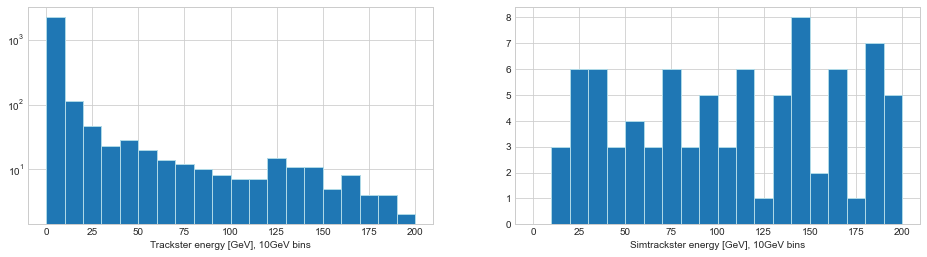

In [5]:
fig = plt.figure(figsize=(16, 4))
plt.style.use('seaborn-whitegrid')
ax = fig.add_subplot(121)
ax.hist(tenergy, bins=20, edgecolor="lightblue", range=(0,200))
ax.set_yscale("log")
ax.set_xlabel("Trackster energy [GeV], 10GeV bins")
ax = fig.add_subplot(122)
ax.set_xlabel("Simtrackster energy [GeV], 10GeV bins")
ax.hist(stenergy, bins=20, edgecolor="lightblue", range=(0,200))
plt.show()

In [6]:
e_pairs = [match_trackster_pairs(
    tracksters,
    simtracksters,
    associations,
    eid,
    energy_threshold=E_TH,
    distance_threshold=100,
    distance_type="bary",
    confidence_threshold=0.5
) for eid in range(ev_per_file)]

e_lc_pairs = [match_trackster_pairs(
    tracksters,
    simtracksters,
    associations,
    eid,
    energy_threshold=E_TH,
    distance_threshold=100,
    distance_type="pairwise",
    confidence_threshold=0.5
) for eid in range(ev_per_file)]

sub-10GeV tracksters distance from nearest large trackster from the same particle distribution

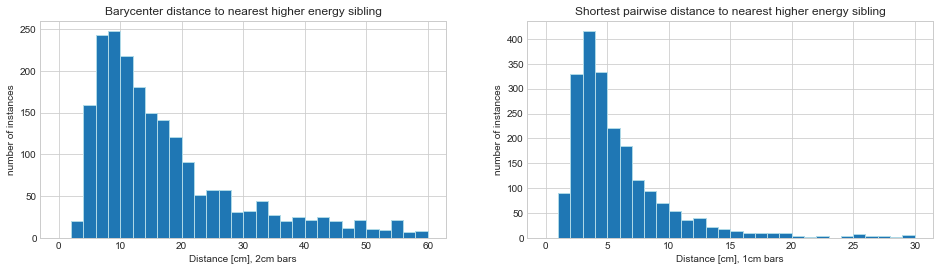

In [7]:
fig = plt.figure(figsize=(16, 4))
plt.style.use('seaborn-whitegrid')
ax = fig.add_subplot(121)
ax.hist(ak.flatten(e_pairs)[:,2], bins=30, edgecolor="lightblue", range=(0,60))
ax.set_title("Barycenter distance to nearest higher energy sibling")
ax.set_xlabel("Distance [cm], 2cm bars")
ax.set_ylabel("number of instances")

ax = fig.add_subplot(122)
ax.hist(ak.flatten(e_lc_pairs)[:,2], bins=30, edgecolor="lightblue", range=(0, 30))
ax.set_title("Shortest pairwise distance to nearest higher energy sibling")
ax.set_xlabel("Distance [cm], 1cm bars")
ax.set_ylabel("number of instances")

plt.show()

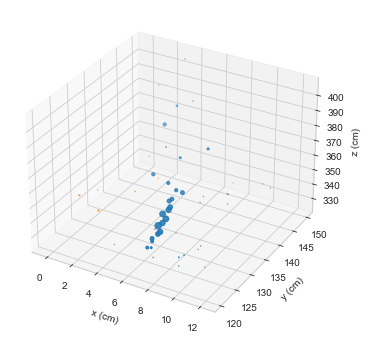

In [10]:
eid = 0
x_lc = tracksters["vertices_x"].array()[eid]
y_lc = tracksters["vertices_y"].array()[eid]
z_lc = tracksters["vertices_z"].array()[eid]
e_lc = tracksters["vertices_energy"].array()[eid]

p_id = 2
indices = [p_id]
fig = plt.figure(figsize=(6, 6))

for i, (tt, lt, dst) in enumerate(e_pairs[eid]):
    if lt == p_id:
        indices.append(tt)

ax = fig.add_subplot(111, projection='3d')
plot_tracksters(ax, x_lc[indices], y_lc[indices], z_lc[indices], e_lc[indices])
plt.show()

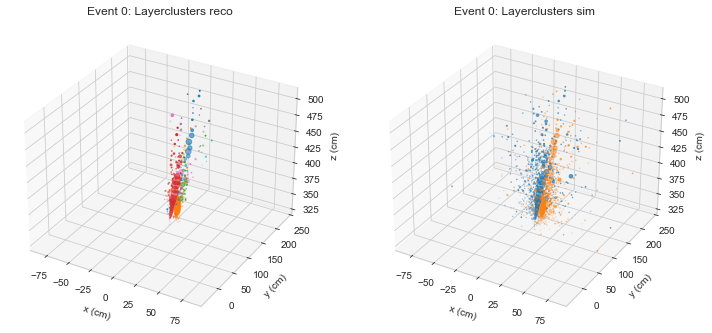

In [11]:
gt = get_ground_truth(
    tracksters,
    simtracksters,
    associations,
    eid
)

plot_sim_reco(
    gt["vertices_x"],
    gt["vertices_y"],
    gt["vertices_z"],
    gt["vertices_energy"],
    simtracksters["stsSC_vertices_x"].array()[eid],
    simtracksters["stsSC_vertices_y"].array()[eid],
    simtracksters["stsSC_vertices_z"].array()[eid],
    simtracksters["stsSC_vertices_energy"].array()[eid],
    simtracksters["stsSC_vertices_indexes"].array()[eid],
    simtracksters["stsSC_vertices_multiplicity"].array()[eid],
    eid,
    legend=False
)

## Getting the ground truth params right

Find which configuration does the best job improving the reconstruction

In [12]:
# explore the parameter
ex = tracksters["vertices_x"].array()
ey = tracksters["vertices_y"].array()
ez = tracksters["vertices_z"].array()
ee = tracksters["vertices_energy"].array()
ei = tracksters["vertices_indexes"].array()
em = tracksters["vertices_multiplicity"].array()

sei = simtracksters["stsSC_vertices_indexes"].array()
see = simtracksters["stsSC_vertices_energy"].array()
sem = simtracksters["stsSC_vertices_multiplicity"].array()

precision_diff = []
recall_diff = []
fscore_diff = []

ng = []
nc = []
ns = []

for eid in range(20):
    gt = get_ground_truth(
        tracksters,
        simtracksters,
        associations,
        eid,
        energy_threshold=20,
        distance_threshold=15,
    )

    gti = gt["vertices_indexes"]
    gte = gt["vertices_energy"]
    gtm = gt["vertices_multiplicity"]

    c2sP, c2sR, c2sF = evaluate(ei[eid], sei[eid], ee[eid], see[eid], em[eid], sem[eid], noise=False)
    g2sP, g2sR, g2sF = evaluate(gti, sei[eid], gte, see[eid], gtm, sem[eid], noise=False)

    print(f"{eid}:\tP {c2sP:.2f}/{g2sP:.2f}\t| R {c2sR:.2f}/{g2sR:.2f}\t| F {c2sF:.2f}/{g2sF:.2f}")

    precision_diff.append(c2sP - g2sP)
    recall_diff.append(c2sR - g2sR)
    fscore_diff.append(c2sF - g2sF)

    ng.append(len(gt["vertices_indexes"]))
    nc.append(len(ee[eid]))
    ns.append(len(sei[eid]))

0:	P 0.94/0.95	| R 0.14/0.44	| F 0.17/0.49
1:	P 0.96/0.96	| R 0.44/0.90	| F 0.49/0.91
2:	P 0.98/0.98	| R 0.23/0.78	| F 0.28/0.81
3:	P 0.88/0.91	| R 0.11/0.34	| F 0.13/0.39
4:	P 0.94/0.94	| R 0.38/0.59	| F 0.44/0.64
5:	P 1.00/1.00	| R 0.51/0.87	| F 0.57/0.90
6:	P 0.88/0.91	| R 0.05/0.25	| F 0.07/0.29
7:	P 1.00/1.00	| R 0.73/1.00	| F 0.77/1.00
8:	P 1.00/1.00	| R 0.39/0.95	| F 0.44/0.96
9:	P 0.92/0.91	| R 0.14/0.43	| F 0.16/0.48
10:	P 1.00/1.00	| R 0.25/0.90	| F 0.29/0.91
11:	P 0.98/0.98	| R 0.32/0.88	| F 0.37/0.90
12:	P 0.95/0.95	| R 0.14/0.41	| F 0.17/0.46
13:	P 1.00/1.00	| R 0.30/0.93	| F 0.35/0.94
14:	P 1.00/1.00	| R 0.21/0.73	| F 0.25/0.78
15:	P 1.00/1.00	| R 0.27/0.65	| F 0.32/0.70
16:	P 0.93/0.95	| R 0.11/0.40	| F 0.14/0.45
17:	P 1.00/1.00	| R 0.17/0.62	| F 0.20/0.67
18:	P 1.00/1.00	| R 0.27/0.78	| F 0.32/0.81
19:	P 0.97/0.97	| R 0.30/0.89	| F 0.35/0.91


In [13]:
print("Precision loss: ", sum(precision_diff), "avg:", np.mean(precision_diff))
print("Recall loss: ", sum(recall_diff), "avg:", np.mean(recall_diff))
print("Fscore loss: ", sum(fscore_diff), "avg:", np.mean(fscore_diff))

Precision loss:  -0.09401999239177616 avg: -0.004700999619588808
Recall loss:  -8.261334492061044 avg: -0.4130667246030522
Fscore loss:  -8.131481257700045 avg: -0.40657406288500225


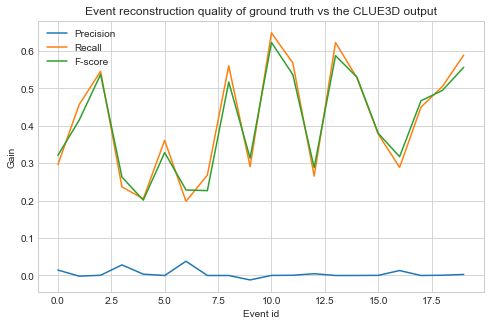

In [14]:
plt.figure(figsize=(8, 5))
plt.plot(-np.array(precision_diff), label="Precision")
plt.plot(-np.array(recall_diff), label="Recall")
plt.plot(-np.array(fscore_diff), label="F-score")
plt.ylabel("Gain")
plt.title("Event reconstruction quality of ground truth vs the CLUE3D output")
plt.xlabel("Event id")
plt.legend()
plt.show()

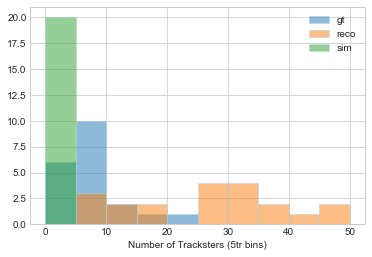

In [15]:
plt.hist(ng, bins=10, edgecolor="lightblue", range=(0, 50), label="gt", alpha=0.5)
plt.hist(nc, bins=10, edgecolor="lightblue", range=(0, 50), label="reco", alpha=0.5)
plt.hist(ns, bins=10, edgecolor="lightblue", range=(0, 50), label="sim", alpha=0.5)
plt.xlabel("Number of Tracksters (5tr bins)")
plt.legend()
plt.show()